In [1]:
import scipy as sc
import pandas as pd 
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import functools
import warnings
import tensorflow_probability as tfp
import tensorflow as tf
from sklearn.mixture import BayesianGaussianMixture
from tensorflow.python.ops.parallel_for.gradients import jacobian

from src.advi_fcts import * 
from src.df_processing import * 


tfd = tfp.distributions

warnings.filterwarnings('ignore')

In [2]:
x = pd.read_csv('../taxi+service+trajectory+prediction+challenge+ecml+pkdd+2015/interpolation'+'200'+'.csv')
dataset = extract_traj(x)
reshaped = np.array([i.reshape(-1) for i in dataset])
reshaped.shape
dataset = tf.cast(tf.transpose(tf.convert_to_tensor(reshaped)), tf.float64)

mu = tf.convert_to_tensor(pd.read_csv('mu_200.csv').to_numpy())
omega = tf.convert_to_tensor(pd.read_csv('omega_200.csv').to_numpy())

In [3]:
num_datapoints = dataset.shape[1]
data_dim = dataset.shape[0]
latent_dim = 11

nb_samples = 30
lr = 0.2

advi_model = ADVI_algorithm(data_dim, latent_dim, num_datapoints, dataset, nb_samples, lr)

In [4]:
zeta = np.random.normal(mu, tf.exp(omega))
n =  advi_model.latent_dim* advi_model.num_datapoints+advi_model.data_dim*advi_model.latent_dim
first_part = zeta[:n]
last_n_elements = zeta[:-n]
last_n_elements = tf.exp(last_n_elements)
par = tf.concat([first_part, last_n_elements], axis=0)


theta = tf.reshape(par, [-1])  
# Extract parameters
z_size = advi_model.latent_dim* advi_model.num_datapoints
w_size = advi_model.data_dim*advi_model.latent_dim

z_flat = theta[:z_size]
w_flat = theta[z_size:z_size + w_size]
sigma = theta[z_size + w_size]

# Reshape z and w
z = tf.reshape(z_flat, [advi_model.latent_dim,advi_model.num_datapoints])
w = tf.reshape(w_flat, [advi_model.data_dim, advi_model.latent_dim])

In [5]:
proj = tf.linalg.inv(tf.transpose(w)@w)@tf.transpose(w)@(dataset - tf.math.log(sigma)).numpy()
trajectories = tf.transpose(proj).numpy()

In [18]:
# Instantiate the BGMM model
n_components = 30  # Number of components (clusters)
bgmm_30 = BayesianGaussianMixture(n_components=n_components, covariance_type='full', random_state=42)

# Fit the model to your data
bgmm_30.fit(trajectories)

# Predict cluster memberships for the trajectories
cluster_memberships_30 = bgmm_30.predict(trajectories)

# You can also obtain the posterior probability of each trajectory belonging to each cluster
posterior_probs_30 = bgmm_30.predict_proba(trajectories)
x['30_clusters'] = cluster_memberships_30

In [19]:
# Instantiate the BGMM model
n_components = 10  # Number of components (clusters)
bgmm_10 = BayesianGaussianMixture(n_components=n_components, covariance_type='full', random_state=42)

# Fit the model to your data
bgmm_10.fit(trajectories)

# Predict cluster memberships for the trajectories
cluster_memberships_10 = bgmm_10.predict(trajectories)

x['10_clusters'] = cluster_memberships_10

In [20]:
# Instantiate the BGMM model
n_components = 2  # Number of components (clusters)
bgmm_2 = BayesianGaussianMixture(n_components=n_components, covariance_type='full', random_state=42)

# Fit the model to your data
bgmm_2.fit(trajectories)

# Predict cluster memberships for the trajectories
cluster_memberships_2 = bgmm_2.predict(trajectories)
x['2_clusters'] = cluster_memberships_2

In [21]:
def generate_colors(n):
    return sns.color_palette("deep", n)

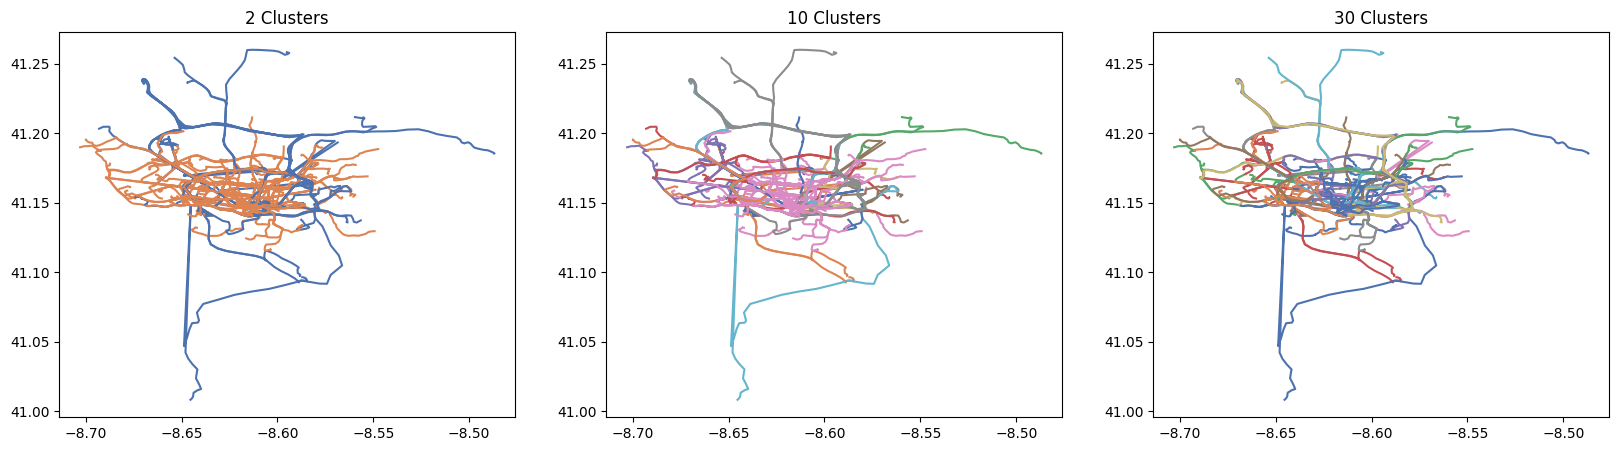

In [22]:
c2 = generate_colors(2)
c10 = generate_colors(10)
c30 = generate_colors(30)

fig, ax = plt.subplots(ncols=3, figsize=(20,5))
for j, i in enumerate(reshaped): 
    r = i.reshape(50,2)
    col2 = c2[cluster_memberships_2[j]]
    col10 = c10[cluster_memberships_10[j]]
    col30 = c30[cluster_memberships_30[j]]
    ax[0].plot(r[:,0], r[:,1], color=col2)
    ax[0].set_title('2 Clusters')
    ax[1].plot(r[:,0], r[:,1], color=col10)
    ax[1].set_title('10 Clusters')
    ax[2].plot(r[:,0], r[:,1], color=col30)
    ax[2].set_title('30 Clusters')
plt.savefig('images/Clusters_200_trajectories.png')
plt.show()